In [1]:
import pandas as pd
import json
import re
import numpy as np

In [2]:
path1 =r'./meta_Gift_Cards.json'
meta_GC = []
with open(path1, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        dic = json.loads(line)
        meta_GC.append(dic)

df_meta_GC = pd.DataFrame(meta_GC)

In [3]:
df_meta_GC_2 = df_meta_GC[['asin', 'feature', 'description','also_buy', 'brand', 'also_view', 'main_cat', 'imageURLHighRes']].copy()

# 数据预处理

In [4]:
df_meta_GC_2['imageURLHighRes_2'] = df_meta_GC_2['imageURLHighRes'].astype(str)
df_meta_GC_2 = df_meta_GC_2.drop_duplicates(['imageURLHighRes_2'])
df_meta_GC_2 = df_meta_GC_2.reset_index(drop=True)

In [5]:
def cleaner(list_feature):
    list_feature = list_feature.replace('\n', '').replace('\r', '')
    list_feature = list_feature.strip()
    pattern = re.compile(r'<[^>]+>',re.S)
    list_feature = pattern.sub('', list_feature)
    return list_feature

row_num = df_meta_GC_2.shape[0]
for i in range(row_num):
    for j in range(len(df_meta_GC_2['feature'][i])):
        df_meta_GC_2['feature'][i][j]=cleaner(df_meta_GC_2['feature'][i][j]) 
        
for i in range(row_num):
    for j in range(len(df_meta_GC_2['description'][i])):
        df_meta_GC_2['description'][i][j]=cleaner(df_meta_GC_2['description'][i][j]) 
        
for i in range(row_num):
    df_meta_GC_2['main_cat'][i]=cleaner(df_meta_GC_2['main_cat'][i]) 

In [6]:
def cleaner2(list_feature):
    result = re.sub(r'[^\s]*[.com]$', '', list_feature)
    result2 = re.compile(r'[http|https]*://[a-zA-Z0-9.?/&=:]*', re.S)
    s = re.sub(result2, '', result)
    return s

row_num = df_meta_GC_2.shape[0]
for i in range(row_num):
    for j in range(len(df_meta_GC_2['feature'][i])):
        df_meta_GC_2['feature'][i][j]=cleaner2(df_meta_GC_2['feature'][i][j]) 
        
for i in range(row_num):
    for j in range(len(df_meta_GC_2['description'][i])):
        df_meta_GC_2['description'][i][j]=cleaner2(df_meta_GC_2['description'][i][j])

for i in range(row_num):
    df_meta_GC_2['main_cat'][i]=cleaner2(df_meta_GC_2['main_cat'][i]) 

In [7]:
def cleaner3(x):
    s = re.sub(r"[^a-zA-Z\s]", "", x)
    return s

df_meta_GC_2['feature'] = df_meta_GC_2['feature'].astype(str)
df_meta_GC_2['description'] = df_meta_GC_2['description'].astype(str)
df_meta_GC_2['feature'] = df_meta_GC_2['feature'].apply(cleaner3)
df_meta_GC_2['description'] = df_meta_GC_2['description'].apply(cleaner3)

In [8]:
df_meta_GC_2['text'] = df_meta_GC_2['feature'] + df_meta_GC_2['description']

In [9]:
selected_index = []
count = 0
for i in range(row_num):
    if (len(df_meta_GC_2['text'][i]) > 0) and (df_meta_GC_2['imageURLHighRes'][i] != list()):
        count = count + 1
        selected_index.append(i)

df_meta_GC_3 = df_meta_GC_2.loc[selected_index].copy()
df_meta_GC_3 = df_meta_GC_3.sort_values(by='asin')
df_meta_GC_3 = df_meta_GC_3.reset_index(drop=True)

In [11]:
# 下载图片
import requests
import os

def download_image(url, filename):
    try:
        response = requests.get(url)
        response.raise_for_status()  # 检查请求是否成功
        with open(filename, 'wb') as file:
            file.write(response.content)
    except (requests.RequestException, IOError) as e:
        print(f"下载 {url} 失败: {str(e)}")

# 创建存储图片的根目录

root_directory = 'D:/system default/桌面/images/'
if not os.path.exists(root_directory):
    os.makedirs(root_directory)

# 遍历每行数据，下载图片
for index, row in df_meta_GC_3.iterrows():
    asin = row['asin']
    image_urls = row['imageURLHighRes']

    for i, url in enumerate(image_urls):
        if(i == 1):
            break
        s = str(asin) + '.jpg'
        filename = os.path.join(root_directory, s)
        download_image(url, filename)

# 将商品的描述Embedding

### 第一次使用

In [10]:
from transformers import AutoTokenizer, AutoModel

In [11]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [12]:
inputs = tokenizer(list(df_meta_GC_3['text']), padding=True, truncation=True, max_length=64, return_tensors="pt")
outputs = model(**inputs)
torch_item_embed = outputs.pooler_output

In [14]:
item_embed = torch_item_embed.detach().numpy()
item_embed.shape

(442, 768)

In [15]:
np.save("item_embedding.npy", item_embed)

### 第二次使用可以直接加载，不用运行第一次使用的代码块

In [10]:
# 第二次使用的时候可以直接加载
item_embed = np.load("item_embedding.npy")
item_embed.shape

(442, 768)

# 多模态融合

In [11]:
import torch

In [12]:
image_embed = pd.read_csv('./img_embed.csv')
image_embed = image_embed.sort_values(by='0')
image_embed_2 = image_embed.iloc[:,1:]
image_embed_3 = image_embed_2.to_numpy()
torch_image_embed = torch.tensor(image_embed_3)

In [13]:
torch_item_embed = torch.tensor(item_embed)

In [14]:
torch_item_embed.shape, torch_image_embed.shape

(torch.Size([442, 768]), torch.Size([442, 768]))

### 根据我们的调参经验，进行简单的加权融合

In [15]:
fusion_TI = 0.25 * torch_item_embed + 0.75 * torch_image_embed

In [16]:
fusion_TI.shape

torch.Size([442, 768])

# 关联规则分析

In [10]:
selected_asin = list(df_meta_GC_3['asin'])

In [11]:
import copy

In [12]:
for i in range(df_meta_GC_3.shape[0]):
    l = []
    for j in range(len(df_meta_GC_3['also_buy'][i])):
        if df_meta_GC_3['also_buy'][i][j] in selected_asin:
            l.append(df_meta_GC_3['also_buy'][i][j])
            
    df_meta_GC_3['also_buy'][i] = copy.deepcopy(l)

In [13]:
for i in range(df_meta_GC_3.shape[0]):
    l = []
    for j in range(len(df_meta_GC_3['also_view'][i])):
        if df_meta_GC_3['also_view'][i][j] in selected_asin:
            l.append(df_meta_GC_3['also_view'][i][j])
            
    df_meta_GC_3['also_view'][i] = copy.deepcopy(l)

In [14]:
df_meta_GC_3.to_csv('Processed_Item_Info.csv', index=False)

In [15]:
data_rules = df_meta_GC_3[['asin','also_buy', 'also_view']].copy()
data_rules['item_set'] = data_rules.apply(lambda row: [row['asin']] + row['also_buy'] + row['also_view'], axis=1)

In [16]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

In [17]:
Item_sets = data_rules['item_set'].tolist()

# 使用TransactionEncoder将二维列表转换为适合关联规则分析的数据格式
te = TransactionEncoder()
te_ary = te.fit_transform(Item_sets)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 参数调整
min_support = 0.15 # 0.19有接近3000个 0.3有十几个
min_threshold = 0.7

# 使用fpgrowth挖掘频繁项集
frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)

# 使用association_rules函数生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold)

In [18]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(B00GOLGWVK),(B00CXZPG0O),0.470588,0.477376,0.393665,0.836538,1.752370,0.169018,3.197232,0.810983
1,(B00CXZPG0O),(B00GOLGWVK),0.477376,0.470588,0.393665,0.824645,1.752370,0.169018,3.019078,0.821516
2,(B00AS527QW),(B00GOLGWVK),0.341629,0.470588,0.305430,0.894040,1.899834,0.144663,4.996324,0.719409
3,(B00AS527QW),(B00CXZPG0O),0.341629,0.477376,0.305430,0.894040,1.872823,0.142345,4.932268,0.707878
4,(B00AS527QW),(B00FTJI60I),0.341629,0.361991,0.242081,0.708609,1.957533,0.118415,2.189531,0.742975
...,...,...,...,...,...,...,...,...,...,...
3973,"(B00BXLVD8I, B00FTJI60I)","(B00GOLGWVK, B00CXZPG0O)",0.160633,0.393665,0.158371,0.985915,2.504452,0.095135,43.049774,0.715672
3974,"(B00BXLVD8I, B00GOLGWVK)","(B00FTJI60I, B00CXZPG0O)",0.192308,0.319005,0.158371,0.823529,2.581560,0.097024,3.858974,0.758503
3975,"(B00BXLVD8I, B00CXZPG0O)","(B00FTJI60I, B00GOLGWVK)",0.205882,0.330317,0.158371,0.769231,2.328767,0.090365,2.901961,0.718519
3976,(B00BXLVD8I),"(B00FTJI60I, B00GOLGWVK, B00CXZPG0O)",0.214932,0.305430,0.158371,0.736842,2.412476,0.092724,2.639367,0.745780


In [19]:
def convert_to_list(x):
    return list(x)

rules['antecedents'] = rules['antecedents'].apply(convert_to_list)
rules['consequents'] = rules['consequents'].apply(convert_to_list)

In [20]:
rules.to_csv('Rules.csv', index=False)

# 读取用户

In [17]:
path2 =r'./Gift_Cards.json'
GC = []
with open(path2, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        dic = json.loads(line)
        GC.append(dic)
        
df_GC = pd.DataFrame(GC)
df_GC_2 = df_GC[['reviewerID', 'reviewerName', 'asin','overall', 'reviewText', 'summary']].copy()

In [18]:
selected_asin = list(df_meta_GC_3['asin'])
asin_index = []
for i in range(df_GC_2.shape[0]):
    if df_GC_2['asin'][i] in selected_asin:
        asin_index.append(i)

In [19]:
df_GC_3 = df_GC_2.loc[asin_index].copy()
df_GC_3 = df_GC_3.drop_duplicates(['reviewText'])
df_GC_3 = df_GC_3.reset_index(drop=True)

In [20]:
df_GC_3['reviewText'] = df_GC_3['reviewText'].astype(str)
df_GC_3['reviewText'] = df_GC_3['reviewText'].apply(cleaner3)

In [21]:
df_GC_4 = df_GC_3.groupby('reviewerID')['reviewText'].apply(lambda x:x.str.cat(sep=' ')).reset_index()
df_GC_4 = df_GC_4.sort_values(by='reviewerID')

# 用户下采样

In [22]:
df_GC_5 = df_GC_4.sample(n=1000, random_state=0).copy()
df_GC_5 = df_GC_5.sort_values(by='reviewerID')

In [23]:
df_GC_5.to_csv('Processed_User_Info.csv', index=False)

In [23]:
selected_usr = list(df_GC_5['reviewerID'])
sampled_index = []
for i in range(df_GC_3.shape[0]):
    if df_GC_3['reviewerID'][i] in selected_usr:
        sampled_index.append(i)
        
df_GC_6 = df_GC_3.loc[sampled_index].copy()
df_GC_6 = df_GC_6.reset_index(drop=True)

In [18]:
from transformers import AutoTokenizer, AutoModel

In [19]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [26]:
inputs2 = tokenizer(list(df_GC_5['reviewText']), padding=True, truncation=True, max_length=64, return_tensors="pt")
outputs2 = model(**inputs2)
torch_user_embed = outputs2.pooler_output

In [28]:
user_embed = torch_user_embed.detach().numpy()
user_embed.shape

(1000, 768)

In [19]:
np.save("user_embedding.npy", user_embed)

In [24]:
user_embed = np.load("user_embedding.npy")
user_embed.shape

(1000, 768)

# 构建推荐系统评分矩阵

In [25]:
item_index = [i for i in range(df_meta_GC_3.shape[0])]
item_val = list(df_meta_GC_3['asin'])
item_dict = dict(zip(item_val, item_index))

In [26]:
usr_index = [i for i in range(df_GC_5.shape[0])]
usr_val = list(df_GC_5['reviewerID']) 
usr_dict = dict(zip(usr_val, usr_index))

In [27]:
rating = np.zeros((len(item_index), len(usr_index)))
for _, row in df_GC_6.iterrows(): 
    item = row['asin']
    user = row['reviewerID']
    item_i = item_dict[item]
    user_i = usr_dict[user]
    rating[item_i, user_i] = row['overall']

print(rating.shape)

(442, 1000)


In [28]:
record = rating > 0
record = np.array(record, dtype=int)

In [29]:
# 对评分取值范围进行缩放
# 定义函数：接受两个参数：电影评分表，评分记录表
def normalizeRating (rating, record):
    m, n = rating.shape # m电影数，n用户数
 # 每个电影每个用户的评分平均值
    rating_mean = np.zeros((m, 1)) # 所有电影平均评分初始化为0
    rating_norm = np.zeros((m, n)) # 保存处理之后的数据
    for i in range(m): # 将原始评分减去平均评分，将结果和平均评分返回
        idx = record[i, :] != 0 # 已评分的电影对应的用户下标
        rating_mean[i] = np.mean(rating[i, idx]) # 记录这些评分的平均值，第i部电影
        rating_norm[i, idx] -= rating_mean[i] # 原始评分减去评分的平均值
    return rating_norm, rating_mean

rating_norm, rating_mean = normalizeRating(rating, record) # 结果提示有全0数据，需处理
rating_norm = np.nan_to_num(rating_norm) # 将nan数据转换为0
rating_mean = np.nan_to_num(rating_mean)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# 训练推荐系统模型，并做消融实验来验证多模态融合的作用

In [30]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [31]:
# 实验1：商品仅仅只有文本表征
# X_parameters = tf.Variable(item_embed)


# 实验2：商品仅仅只有图片表征
# X_parameters = tf.Variable(image_embed_3)


# 实验3：商品的文本和图片多模态融合表征
fusion_TI = fusion_TI.numpy()
X_parameters = tf.Variable(fusion_TI)

#---------------------------------------------------------------------------------------------------------------------------------
Theta_parameters = tf.Variable(user_embed)
X_parameters = tf.cast(X_parameters,dtype=tf.float32)
Theta_parameters = tf.cast(Theta_parameters,dtype=tf.float32)

In [32]:
type(X_parameters), type(Theta_parameters)

(tensorflow.python.framework.ops.Tensor,
 tensorflow.python.framework.ops.Tensor)

In [33]:
loss = 1/2 * tf.reduce_sum(((tf.matmul(X_parameters, Theta_parameters,
transpose_b=True) - rating_norm) * record) ** 2) + 1/2 * (tf.reduce_sum(X_parameters ** 2) + tf.reduce_sum(Theta_parameters ** 2))

In [34]:
tf.compat.v1.disable_eager_execution()

# 创建adam优化器和优化目标
optimizer = tf.compat.v1.train.AdamOptimizer(10**-4) # 学习速率10^-4
train = optimizer.minimize(loss) # 目标：最小化代价函数
train = tf.compat.v1.train.GradientDescentOptimizer(0.0001).minimize(loss)

In [35]:
# 由于loss值是标量，所以要用summary中的scalar
tf.compat.v1.summary.scalar('loss', loss)

# 将所有summary信息汇总
summaryMerged = tf.compat.v1.summary.merge_all()

# 创建tensorflow会话
sess = tf.compat.v1.Session()
init = tf.compat.v1.global_variables_initializer()
sess.run(init)

#loss_list = []
#error_list = []
for i in range(20000):
    movie_summary = sess.run([train, summaryMerged]) 
    sess.run(loss)
    #ls = sess.run(loss)
    #loss_list.append(ls)
    #Current_X_parameters, Current_Theta_parameters = sess.run([X_parameters, Theta_parameters])
    #predicts = np.dot(Current_X_parameters, Current_Theta_parameters.T) + rating_mean
    #errors = np.sqrt(np.sum((predicts - rating)**2))
    #error_list.append(errors)
    #if i % 50 == 0:
        #print(i, ls, errors)

2023-09-05 13:30:28.823351: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 13:30:30.687040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21816 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6
2023-09-05 13:30:32.273613: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


# 消融实验

In [30]:
# Only text embedding for item
Current_X_parameters, Current_Theta_parameters = sess.run([X_parameters, Theta_parameters])
predicts = np.dot(Current_X_parameters, Current_Theta_parameters.T) + rating_mean
errors1 = np.sqrt(np.sum((predicts - rating)**2))
errors1

2564.7210566628173

In [32]:
# Only image embedding for item
Current_X_parameters, Current_Theta_parameters = sess.run([X_parameters, Theta_parameters])
predicts = np.dot(Current_X_parameters, Current_Theta_parameters.T) + rating_mean
errors2 = np.sqrt(np.sum((predicts - rating)**2))
errors2

1407.3795302556043

In [37]:
# Multimodal fustion of text embedding and image embedding for item
Current_X_parameters, Current_Theta_parameters = sess.run([X_parameters, Theta_parameters])
predicts = np.dot(Current_X_parameters, Current_Theta_parameters.T) + rating_mean
errors3 = np.sqrt(np.sum((predicts - rating)**2))
errors3

1189.8983152359126

# 可视化训练过程

In [35]:
# 由于loss值是标量，所以要用summary中的scalar
tf.compat.v1.summary.scalar('loss', loss)

# 将所有summary信息汇总
summaryMerged = tf.compat.v1.summary.merge_all()

# 创建tensorflow会话
sess = tf.compat.v1.Session()
init = tf.compat.v1.global_variables_initializer()
sess.run(init)

loss_list = []
error_list = []
for i in range(20000):
    movie_summary = sess.run([train, summaryMerged]) 
    ls = sess.run(loss)
    loss_list.append(ls)
    Current_X_parameters, Current_Theta_parameters = sess.run([X_parameters, Theta_parameters])
    predicts = np.dot(Current_X_parameters, Current_Theta_parameters.T) + rating_mean
    errors = np.sqrt(np.sum((predicts - rating)**2))
    error_list.append(errors)
    #if i % 50 == 0:
        #print(i, ls, errors)

2023-09-03 12:57:41.181932: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 12:57:42.870100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21816 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6
2023-09-03 12:57:44.459189: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


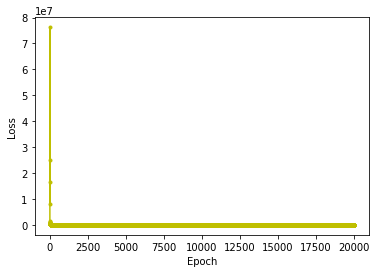

In [36]:
import matplotlib.pyplot as plt
x = [i for i in range(len(loss_list))]
plt.plot(x,loss_list,'y.-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

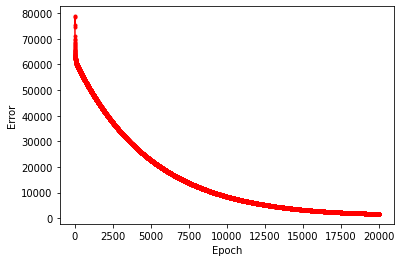

In [37]:
plt.plot(x,error_list,'r.-')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

In [38]:
# 使用前面得到的参数，填满电影评分表
 
# 获取当前X和theta
Current_X_parameters, Current_Theta_parameters = sess.run([X_parameters, Theta_parameters])
 
# 将电影内容矩阵和用户喜好矩阵相乘，再加上每一行的均值，得到一个完整的电影评分表
# dot用于矩阵之间的乘法操作
predicts = np.dot(Current_X_parameters, Current_Theta_parameters.T) + rating_mean
np.save("predicts.npy", predicts)

# 计算用户相似度

In [45]:
predicts2 = predicts.T
predicts2.shape

(1000, 442)

In [47]:
user_sim_matrix = np.zeros((1000, 1000))    
for i in range(1000):
    for j in range(1000):
        vec1 = predicts2[i]
        vec2 = predicts2[j]
        cos_sim = vec1.dot(vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        user_sim_matrix[i, j] = cos_sim

In [56]:
user_sim_matrix2 = np.zeros((1000, 1000))    
for i in range(1000):
    for j in range(1000):
        vec1 = user_embed[i]
        vec2 = user_embed[j]
        cos_sim = vec1.dot(vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        user_sim_matrix2[i, j] = cos_sim

In [61]:
user_sim_matrix_all = 0.5 * user_sim_matrix + 0.5 * user_sim_matrix2

In [62]:
np.save("user_sim_matrix_all.npy", user_sim_matrix_all)

# 开始推荐

In [29]:
predicts = np.load("predicts.npy")

In [30]:
user_sim_matrix_all = np.load("user_sim_matrix_all.npy")

In [31]:
df_meta_GC_3 = pd.read_csv('Processed_Item_Info.csv')

In [32]:
df_GC_5 = pd.read_csv('Processed_User_Info.csv')

In [33]:
rules = pd.read_csv('Rules.csv')
rules['antecedents'] = rules['antecedents'].map(eval)
rules['consequents'] = rules['consequents'].map(eval)

In [37]:
# 获取用户ID，并保存
user_id = input('您要向哪位用户进行推荐？请输入用户编号(0-999)：')
 
# 获取对该用户电影评分的列表
# 预测出的用户对电影的评分，并从大到小排序
sortedResult = predicts[:, int(user_id)].argsort()[::-1]

recommended_num = 20
# 向该用户推荐评分最高的20部电影
idx = 0 # 保存已经推荐了多少部电影
print()
print('为该用户推荐的评分最高的20个Gift Card商品是'.center(80, '='))
 
# 开始推荐
#填空输出推荐内容
#*************************************************************************************************************************
reco_item_list = []
for i in sortedResult:
    reco_item = df_meta_GC_3.iloc[i]['asin']
    print('预测评分：%.2f, 商品ID：%s'% (predicts[i, int(user_id)], reco_item))
    reco_item_list.append(reco_item)
    idx += 1 
    if idx == recommended_num: break

print()
num = 5
num_idx = 0
for item in reco_item_list:
    for j in range(rules.shape[0]):
        if item in rules['antecedents'][j]:
            print('根据关联规则分析')
            print('对于商品', item, '您可以进一步购买', rules['consequents'][j])
            print('Support:', rules['support'][j])
            print('Confidence:', rules['confidence'][j])
            print('Lift:', rules['lift'][j])
            print()
            num_idx += 1
            if num_idx == num: break

print()
print('此外，您可能感兴趣的用户有：'.center(80, '='))
sortedResult = user_sim_matrix_all[:, int(user_id)].argsort()[::-1]

recommended_user_num = 10
idx2 = 0 # 保存已经推荐了多少部电影
 
# 开始推荐///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////;///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
#填空输出推荐内容
#*************************************************************************************************************************
for i in sortedResult:
    print('相似度：%.2f, 用户ID：%s'% (user_sim_matrix_all[i, int(user_id)], df_GC_5.iloc[i]['reviewerID']))
    idx2 += 1 
    if idx2 == recommended_user_num: break

您要向哪位用户进行推荐？请输入用户编号(0-999)： 9



==========================为该用户推荐的评分最高的20个Gift Card商品是===========================
预测评分：32.88, 商品ID：B004Q7CK9M
预测评分：6.02, 商品ID：B00MV9K620
预测评分：5.75, 商品ID：B00ELQD5K6
预测评分：5.75, 商品ID：B00BXLV9NM
预测评分：5.60, 商品ID：B01E4QRAX0
预测评分：5.22, 商品ID：B00UUCWCPE
预测评分：5.09, 商品ID：B00O3YKR48
预测评分：4.94, 商品ID：B00UW1CEMY
预测评分：4.74, 商品ID：B00CXZP74Y
预测评分：4.69, 商品ID：B00BXLTJ8O
预测评分：4.64, 商品ID：B016PASXA2
预测评分：4.57, 商品ID：B00KFLZOWS
预测评分：4.54, 商品ID：B00YD74M4Q
预测评分：4.51, 商品ID：B00BXLSM0A
预测评分：4.49, 商品ID：B01B25L7US
预测评分：4.25, 商品ID：B00BXLUXYS
预测评分：4.11, 商品ID：B00OGQ7SAO
预测评分：4.08, 商品ID：B00BXLVD8I
预测评分：3.79, 商品ID：B00FTGSKL6
预测评分：3.64, 商品ID：B00BXLVQLM

根据关联规则分析
对于商品 B00BXLVD8I 您可以进一步购买 ['B00CXZPG0O']
Support: 0.2058823529411764
Confidence: 0.9578947368421052
Lift: 2.0065851833374904

根据关联规则分析
对于商品 B00BXLVD8I 您可以进一步购买 ['B00GOLGWVK']
Support: 0.1923076923076923
Confidence: 0.8947368421052632
Lift: 1.9013157894736843

根据关联规则分析
对于商品 B00BXLVD8I 您可以进一步购买 ['B009HE86FQ']
Support: 0.1877828054298642
Confidence: 0.8736842105263157
